### SYSTEM IDENTIFICATION USING REGRESSION

In [1]:
# load library

import numpy as np
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
#synthetic data generation

def sys(t, x, ufun):
    u = ufun(t)
    dx1 = x[1]
    dx2 = -0.5*x[0] - 0.2*x[1] + 2.0*u + 0.1*x[0]*x[1]
    return [dx1, dx2]

def ufun(t):
    return np.sin(0.5*t)

dt, T = 0.01, 10
teval = np.arange(0, T, dt)
x0 = [0.0, 0.0]

sol = solve_ivp(lambda t, x: sys(t, x, ufun), [0, T], x0, t_eval=teval)
t = sol.t
x_true = sol.y.T
u = np.array([ufun(tt) for tt in t])

noise = 0.02
x_noisy = x_true + noise * np.random.randn(*x_true.shape)



In [3]:
win, poly = 31, 2
x1s = savgol_filter(x_noisy[:, 0], win, poly, delta=dt)
x2s = savgol_filter(x_noisy[:, 1], win, poly, delta=dt)
dx2s = savgol_filter(x_noisy[:, 1], win, poly, deriv=1, delta=dt)

dx2_true = -0.5*x_true[:, 0] - 0.2*x_true[:, 1] + 2.0*u + 0.1*x_true[:, 0]*x_true[:, 1]

print("="*60)
print("METHOD 1: Manual Features")
print("="*60)

Phi1 = np.column_stack([x1s, x2s, u, x1s*x2s, x1s**2])
names = ['x1', 'x2', 'u', 'x1*x2', 'x1^2']

lr = LinearRegression()
lr.fit(Phi1, dx2s)

print("Intercept:", lr.intercept_)
for i, n in enumerate(names):
    print(f"{n:8}: {lr.coef_[i]:.4f} (true: {[-0.5, -0.2, 2.0, 0.1, 0][i]})")

print("\n" + "="*60)

METHOD 1: Manual Features
Intercept: -0.034730566737822155
x1      : -0.5044 (true: -0.5)
x2      : -0.2083 (true: -0.2)
u       : 2.0665 (true: 2.0)
x1*x2   : 0.0995 (true: 0.1)
x1^2    : 0.0007 (true: 0)



METHOD 2: LASSO
Alpha: 1.00e-10

LASSO Coeffs:
Intercept: -0.034731
x1      : true=-0.500, est=  -0.504, err=   0.004
x2      : true=-0.200, est=  -0.208, err=   0.008
u       : true= 2.000, est=   2.067, err=   0.067
x1*x2   : true= 0.100, est=   0.100, err=   0.000
x1^2    : true= 0.000, est=   0.001, err=   0.001

METHOD 3: Ridge
Alpha: 2.31e-02
Intercept: -0.032518
x1      : true=-0.500, est=  -0.504, err=   0.004
x2      : true=-0.200, est=  -0.208, err=   0.008
u       : true= 2.000, est=   2.062, err=   0.062
x1*x2   : true= 0.100, est=   0.100, err=   0.000
x1^2    : true= 0.000, est=   0.001, err=   0.001

METHOD 4: Subset Selection
Best subset:
  x1: -2.7699
  x2: -0.7370
  u: 1.4701
  x1*x2: 1.5840
  x1^2: 0.0222


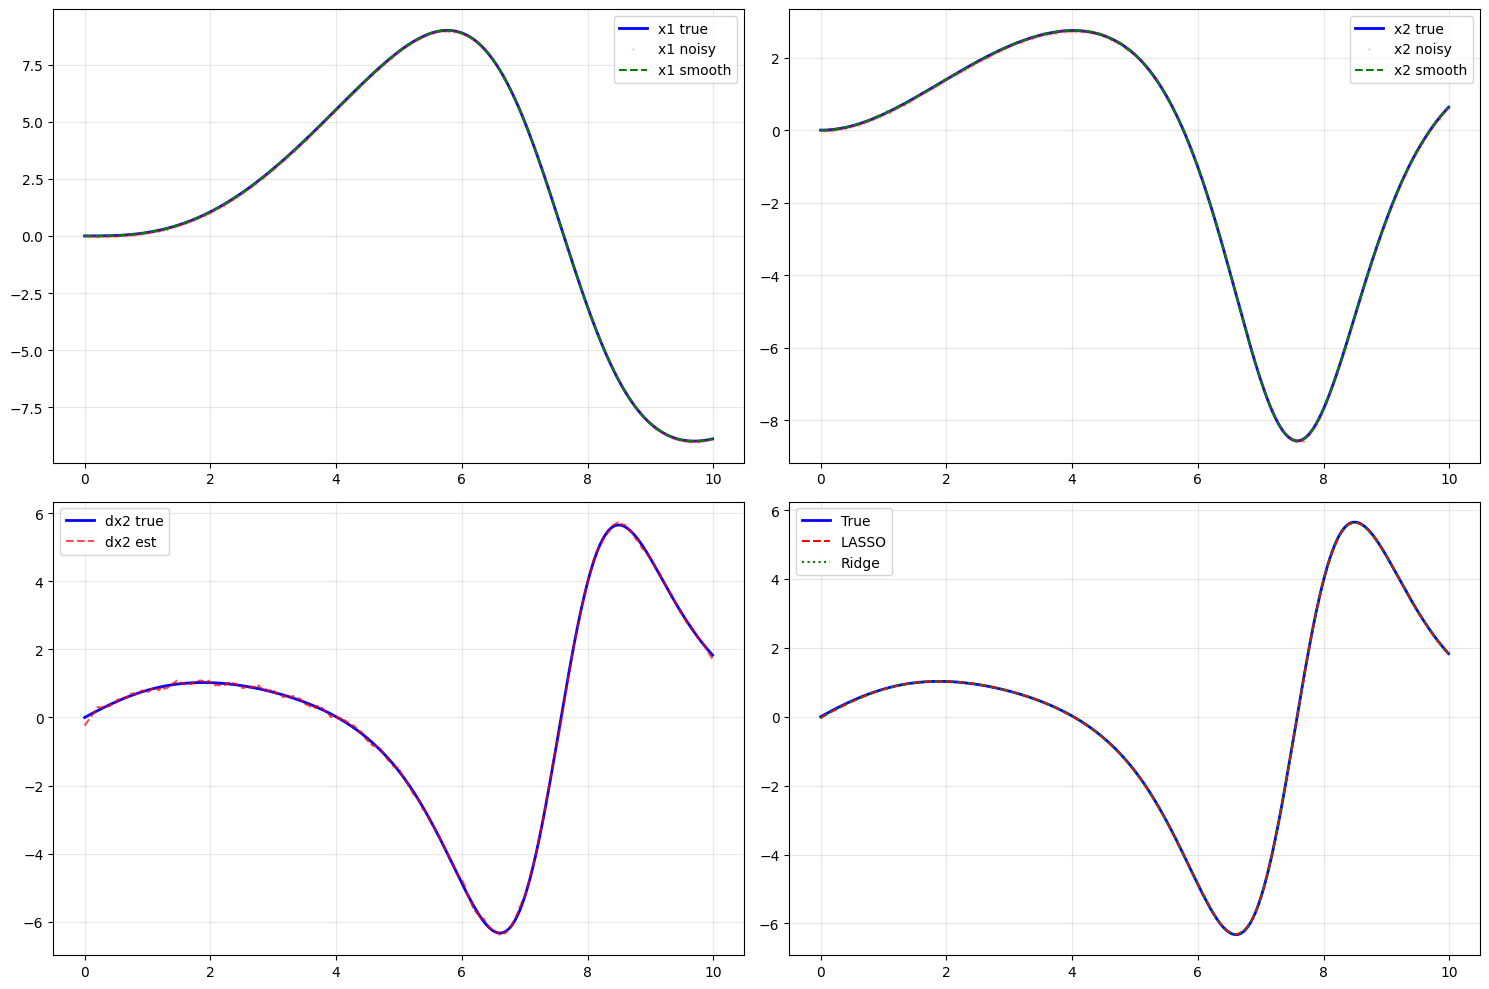

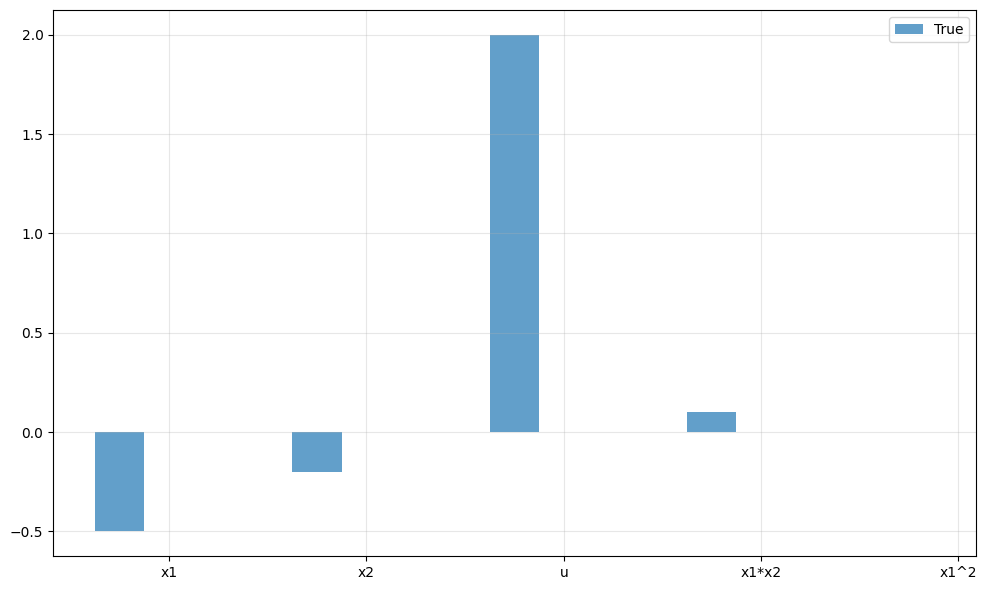


Done!


In [4]:
print("METHOD 2: LASSO")
print("="*60)
Phi = np.column_stack([x1s, x2s, u, x1s*x2s, x1s**2])
sc = StandardScaler()
Phi_sc = sc.fit_transform(Phi)

alphas = np.logspace(-10, -2, 100)
ls = LassoCV(alphas=alphas, cv=5, max_iter=100000, tol=1e-8, random_state=42, n_jobs=-1)
ls.fit(Phi_sc, dx2s)

print(f"Alpha: {ls.alpha_:.2e}")

coef = ls.coef_ / sc.scale_
intercept = ls.intercept_ - np.sum(ls.coef_ * sc.mean_ / sc.scale_)

true_c = np.array([-0.5, -0.2, 2.0, 0.1,0])

print("\nLASSO Coeffs:")
print(f"Intercept: {intercept:.6f}")
for i, n in enumerate(names):
    err = abs(coef[i] - true_c[i])
    print(f"{n:8}: true={true_c[i]:6.3f}, est={coef[i]:8.3f}, err={err:8.3f}")

print("\n" + "="*60)
print("METHOD 3: Ridge")
print("="*60)

rg = RidgeCV(alphas=np.logspace(-6, 6, 100), cv=5)
rg.fit(Phi_sc, dx2s)

coef_r = rg.coef_ / sc.scale_
intercept_r = rg.intercept_ - np.sum(rg.coef_ * sc.mean_ / sc.scale_)

print(f"Alpha: {rg.alpha_:.2e}")
print(f"Intercept: {intercept_r:.6f}")
for i, n in enumerate(names):
    err = abs(coef_r[i] - true_c[i])
    print(f"{n:8}: true={true_c[i]:6.3f}, est={coef_r[i]:8.3f}, err={err:8.3f}")

print("\n" + "="*60)
print("METHOD 4: Subset Selection")
print("="*60)

best_s, best_f, best_c = np.inf, None, None
for k in range(1, len(names) + 1):
    for idx in combinations(range(len(names)), k):
        Xs = Phi_sc[:, list(idx)]
        lr = LinearRegression()
        lr.fit(Xs, dx2s)
        s = np.mean((lr.predict(Xs) - dx2s) ** 2)
        if s < best_s:
            best_s, best_f, best_c = s, idx, lr.coef_

print("Best subset:")
for idx in best_f:
    print(f"  {names[idx]}: {best_c[list(best_f).index(idx)]:.4f}")

dx2_ls = intercept + Phi @ coef
dx2_rg = intercept_r + Phi @ coef_r

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(t, x_true[:, 0], 'b-', lw=2, label='x1 true')
ax[0, 0].plot(t, x_noisy[:, 0], 'r.', ms=1, alpha=0.3, label='x1 noisy')
ax[0, 0].plot(t, x1s, 'g--', lw=1.5, label='x1 smooth')
ax[0, 0].legend(); ax[0, 0].grid(alpha=0.3)

ax[0, 1].plot(t, x_true[:, 1], 'b-', lw=2, label='x2 true')
ax[0, 1].plot(t, x_noisy[:, 1], 'r.', ms=1, alpha=0.3, label='x2 noisy')
ax[0, 1].plot(t, x2s, 'g--', lw=1.5, label='x2 smooth')
ax[0, 1].legend(); ax[0, 1].grid(alpha=0.3)

ax[1, 0].plot(t, dx2_true, 'b-', lw=2, label='dx2 true')
ax[1, 0].plot(t, dx2s, 'r--', lw=1.5, alpha=0.7, label='dx2 est')
ax[1, 0].legend(); ax[1, 0].grid(alpha=0.3)

ax[1, 1].plot(t, dx2_true, 'b-', lw=2, label='True')
ax[1, 1].plot(t, dx2_ls, 'r--', lw=1.5, label='LASSO')
ax[1, 1].plot(t, dx2_rg, 'g:', lw=1.5, label='Ridge')
ax[1, 1].legend(); ax[1, 1].grid(alpha=0.3)

plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
xpos = np.arange(len(names))
w = 0.25
ax.bar(xpos - w, true_c, w, label='True', alpha=0.7)
ax.set_xticks(xpos); ax.set_xticklabels(names)
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout(); plt.show()

print("\nDone!")
